In [1]:

import pyvarinf
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import models, transforms
from tqdm import tqdm
from PIL import Image
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision.transforms import ToTensor


In [2]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
# HYPERPARAMETER:
train_data_dir = "/home/aidanxue/dataset/MW_gen_train"
# TODO
val_data_dir = "/home/aidanxue/dataset/MW_test"
n_epoch = 500
batch_size = 16
lrate = 5e-3
save_model = False
save_dir = '/home/aidanxue/variational_inference/pyvarinf_git/pyvarinf/output'

In [14]:
class MyDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.images = []
        self.labels = []

        for filename in os.listdir(self.path):
            if filename.endswith(".png"):
                # name as "rotated_{}_new_{id}_{mass}_{position}.png"
                if filename.split("_")[0] == "generate":
                    self.images.append(os.path.join(self.path, filename))
                    self.labels.append(float(filename.split("_")[3][:4]))
                else:
                    self.images.append(os.path.join(self.path, filename))
                    self.labels.append(float(filename.split("_")[1]))
            elif filename.endswith(".jpg"):
                # name as "rotated_{}_new_{id}_{mass}_{position}.png"
                self.images.append(os.path.join(self.path, filename))
                self.labels.append(float(filename.split("_")[2]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            if img.size[0] != 128:
                img = self.transform(img)
            else:
                img = ToTensor()(img) 
        return img, label

In [15]:
# INIT DATALOADER
tf = transforms.Compose(
    [
        transforms.CenterCrop(212),
        transforms.Resize(128, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        #transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
    ]
)
tarin_dataset = MyDataset(train_data_dir,transform=tf)
val_dataset = MyDataset(val_data_dir,transform=tf)
train_dataloader = DataLoader(tarin_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
print(len(tarin_dataset))
print(len(val_dataset))


4476
300


In [16]:
class Net(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(512, 64)
        self.mean = nn.Linear(64, 1)
        self.rho = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.pool(x)
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        # use softplus to make sure the variance >= 0
        return self.mean(x), torch.nn.functional.softplus(self.rho(x))
    
model = Net()
var_model = model

if use_cuda:
    var_model = var_model.cuda()

optimizer = torch.optim.Adam(var_model.parameters(), lr=lrate)

In [17]:
def train(epoch):
    print(f'epoch {epoch}')
    var_model.train()
    pbar = tqdm(train_dataloader)
    # for batch_idx, (data, target) in enumerate(train_loader):
    for data, target in pbar:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        if(data.shape[0] != 16):
            continue
        # torch.Size([16, 3, 128, 128])
        optimizer.zero_grad()
        output = var_model(data)
        loss = 0
        for i in range (0,target.shape[0]):
            dist = torch.distributions.normal.Normal(output[0][i], output[1][i])
            loss_per_image = -dist.log_prob(target[i])
            # if (loss_per_image < 0) :
            #   print("mean:", output[0][i].item(), "variance:", output[1][i].item(), "target:", target[i].item())
            loss += loss_per_image
        loss = loss/target.shape[0]
        loss.backward()
        pbar.set_description(f"loss: {loss.item():.4f}")
        optimizer.step()
#def train_VI():
for epoch in range(1, n_epoch):
    train(epoch)

epoch 1


loss: 63.0167: 100%|██████████| 280/280 [00:10<00:00, 26.01it/s]   


epoch 2


loss: 44.4260: 100%|██████████| 280/280 [00:10<00:00, 25.56it/s]  


epoch 3


loss: 33.9983: 100%|██████████| 280/280 [00:11<00:00, 25.26it/s] 


epoch 4


loss: 35.4493: 100%|██████████| 280/280 [00:11<00:00, 25.11it/s] 


epoch 5


loss: 17.7318: 100%|██████████| 280/280 [00:10<00:00, 25.88it/s] 


epoch 6


loss: 22.3604: 100%|██████████| 280/280 [00:11<00:00, 25.33it/s]


epoch 7


loss: 11.4070: 100%|██████████| 280/280 [00:10<00:00, 25.62it/s] 


epoch 8


loss: 17.4301: 100%|██████████| 280/280 [00:11<00:00, 25.05it/s]


epoch 9


loss: 43.8648: 100%|██████████| 280/280 [00:11<00:00, 25.30it/s]


epoch 10


loss: 13.3508: 100%|██████████| 280/280 [00:10<00:00, 25.73it/s]


epoch 11


loss: 10.8482: 100%|██████████| 280/280 [00:10<00:00, 25.59it/s]


epoch 12


loss: 6.4410: 100%|██████████| 280/280 [00:11<00:00, 24.70it/s] 


epoch 13


loss: 6.3934: 100%|██████████| 280/280 [00:10<00:00, 26.21it/s] 


epoch 14


loss: 5.3094: 100%|██████████| 280/280 [00:10<00:00, 25.57it/s] 


epoch 15


loss: 8.2166: 100%|██████████| 280/280 [00:11<00:00, 24.73it/s] 


epoch 16


loss: 6.2442: 100%|██████████| 280/280 [00:11<00:00, 25.34it/s] 


epoch 17


loss: 4.2981: 100%|██████████| 280/280 [00:10<00:00, 25.59it/s]


epoch 18


loss: 3.8614: 100%|██████████| 280/280 [00:11<00:00, 25.43it/s] 


epoch 19


loss: 3.9685: 100%|██████████| 280/280 [00:11<00:00, 24.50it/s] 


epoch 20


loss: 3.6859: 100%|██████████| 280/280 [00:11<00:00, 24.55it/s] 


epoch 21


loss: 3.7629: 100%|██████████| 280/280 [00:11<00:00, 24.92it/s] 


epoch 22


loss: 3.4184: 100%|██████████| 280/280 [00:11<00:00, 25.14it/s]


epoch 23


loss: 3.3869: 100%|██████████| 280/280 [00:11<00:00, 25.22it/s]


epoch 24


loss: 3.4317: 100%|██████████| 280/280 [00:12<00:00, 23.28it/s] 


epoch 25


loss: 3.4679: 100%|██████████| 280/280 [00:11<00:00, 23.40it/s] 


epoch 26


loss: 3.2811: 100%|██████████| 280/280 [00:11<00:00, 24.39it/s] 


epoch 27


loss: 3.1757: 100%|██████████| 280/280 [00:11<00:00, 24.60it/s]


epoch 28


loss: 3.2384: 100%|██████████| 280/280 [00:11<00:00, 24.83it/s] 


epoch 29


loss: 3.1585: 100%|██████████| 280/280 [00:11<00:00, 25.24it/s]


epoch 30


loss: 2.9889: 100%|██████████| 280/280 [00:11<00:00, 25.26it/s]


epoch 31


loss: 3.2160: 100%|██████████| 280/280 [00:10<00:00, 25.53it/s] 


epoch 32


loss: 3.1804: 100%|██████████| 280/280 [00:11<00:00, 25.24it/s] 


epoch 33


loss: 3.1739: 100%|██████████| 280/280 [00:11<00:00, 24.78it/s]


epoch 34


loss: 3.2037: 100%|██████████| 280/280 [00:11<00:00, 25.22it/s]


epoch 35


loss: 3.0926: 100%|██████████| 280/280 [00:11<00:00, 24.79it/s]


epoch 36


loss: 3.3096: 100%|██████████| 280/280 [00:11<00:00, 24.70it/s]


epoch 37


loss: 2.8416: 100%|██████████| 280/280 [00:11<00:00, 24.28it/s]


epoch 38


loss: 2.8101: 100%|██████████| 280/280 [00:11<00:00, 24.84it/s]


epoch 39


loss: 2.9443: 100%|██████████| 280/280 [00:11<00:00, 24.89it/s]


epoch 40


loss: 2.5917: 100%|██████████| 280/280 [00:10<00:00, 25.87it/s]


epoch 41


loss: 2.7977: 100%|██████████| 280/280 [00:11<00:00, 23.50it/s]


epoch 42


loss: 2.8225: 100%|██████████| 280/280 [00:11<00:00, 24.22it/s]


epoch 43


loss: 2.4983: 100%|██████████| 280/280 [00:11<00:00, 24.97it/s]


epoch 44


loss: 2.4284: 100%|██████████| 280/280 [00:11<00:00, 23.99it/s]


epoch 45


loss: 2.6645: 100%|██████████| 280/280 [00:10<00:00, 25.95it/s]


epoch 46


loss: 2.6710: 100%|██████████| 280/280 [00:11<00:00, 24.49it/s]


epoch 47


loss: 2.3943: 100%|██████████| 280/280 [00:11<00:00, 24.31it/s]


epoch 48


loss: 2.6009: 100%|██████████| 280/280 [00:10<00:00, 25.72it/s]


epoch 49


loss: 2.4122: 100%|██████████| 280/280 [00:11<00:00, 25.02it/s]


epoch 50


loss: 2.5625: 100%|██████████| 280/280 [00:11<00:00, 24.54it/s]


epoch 51


loss: 2.2314: 100%|██████████| 280/280 [00:11<00:00, 23.89it/s]


epoch 52


loss: 2.0056: 100%|██████████| 280/280 [00:11<00:00, 25.08it/s]


epoch 53


loss: 2.0100: 100%|██████████| 280/280 [00:11<00:00, 24.88it/s]


epoch 54


loss: 2.2986: 100%|██████████| 280/280 [00:10<00:00, 25.55it/s]


epoch 55


loss: 2.3276: 100%|██████████| 280/280 [00:11<00:00, 24.39it/s]


epoch 56


loss: 2.0408: 100%|██████████| 280/280 [00:11<00:00, 24.38it/s]


epoch 57


loss: 1.9012: 100%|██████████| 280/280 [00:11<00:00, 25.17it/s]


epoch 58


loss: 2.1121: 100%|██████████| 280/280 [00:11<00:00, 24.72it/s]


epoch 59


loss: 1.7976: 100%|██████████| 280/280 [00:11<00:00, 25.19it/s]


epoch 60


loss: 2.0439: 100%|██████████| 280/280 [00:11<00:00, 23.88it/s]


epoch 61


loss: 1.9323: 100%|██████████| 280/280 [00:11<00:00, 23.87it/s]


epoch 62


loss: 1.6098: 100%|██████████| 280/280 [00:10<00:00, 25.51it/s]


epoch 63


loss: 1.6480: 100%|██████████| 280/280 [00:11<00:00, 24.28it/s]


epoch 64


loss: 1.6927: 100%|██████████| 280/280 [00:11<00:00, 23.72it/s]


epoch 65


loss: 1.9386: 100%|██████████| 280/280 [00:11<00:00, 24.91it/s]


epoch 66


loss: 1.6561: 100%|██████████| 280/280 [00:11<00:00, 23.98it/s]


epoch 67


loss: 1.8561: 100%|██████████| 280/280 [00:11<00:00, 24.93it/s]


epoch 68


loss: 1.4027: 100%|██████████| 280/280 [00:11<00:00, 24.37it/s]


epoch 69


loss: 1.3426: 100%|██████████| 280/280 [00:11<00:00, 24.39it/s]


epoch 70


loss: 1.4872: 100%|██████████| 280/280 [00:11<00:00, 24.35it/s]


epoch 71


loss: 1.5727: 100%|██████████| 280/280 [00:11<00:00, 25.10it/s]


epoch 72


loss: 1.4600: 100%|██████████| 280/280 [00:11<00:00, 24.27it/s]


epoch 73


loss: 1.6411: 100%|██████████| 280/280 [00:11<00:00, 24.69it/s]


epoch 74


loss: 1.5596: 100%|██████████| 280/280 [00:11<00:00, 24.67it/s]


epoch 75


loss: 1.6399: 100%|██████████| 280/280 [00:11<00:00, 24.77it/s]


epoch 76


loss: 1.4359: 100%|██████████| 280/280 [00:11<00:00, 24.37it/s]


epoch 77


loss: 1.1229: 100%|██████████| 280/280 [00:12<00:00, 23.08it/s]


epoch 78


loss: 1.0798: 100%|██████████| 280/280 [00:11<00:00, 24.57it/s]


epoch 79


loss: 1.8141: 100%|██████████| 280/280 [00:11<00:00, 25.17it/s]


epoch 80


loss: 0.9764: 100%|██████████| 280/280 [00:11<00:00, 24.47it/s]


epoch 81


loss: 0.8431: 100%|██████████| 280/280 [00:11<00:00, 25.36it/s]


epoch 82


loss: 0.9547: 100%|██████████| 280/280 [00:11<00:00, 23.67it/s]


epoch 83


loss: 0.7267: 100%|██████████| 280/280 [00:11<00:00, 24.15it/s]


epoch 84


loss: 0.9031: 100%|██████████| 280/280 [00:11<00:00, 24.63it/s]


epoch 85


loss: 1.1857: 100%|██████████| 280/280 [00:11<00:00, 24.14it/s]


epoch 86


loss: 0.7104: 100%|██████████| 280/280 [00:11<00:00, 25.10it/s]


epoch 87


loss: 0.7779: 100%|██████████| 280/280 [00:11<00:00, 25.06it/s]


epoch 88


loss: 0.9125: 100%|██████████| 280/280 [00:11<00:00, 24.32it/s]


epoch 89


loss: 0.3134: 100%|██████████| 280/280 [00:11<00:00, 24.18it/s]


epoch 90


loss: 0.3013: 100%|██████████| 280/280 [00:11<00:00, 24.03it/s]


epoch 91


loss: 1.0006: 100%|██████████| 280/280 [00:11<00:00, 25.15it/s]


epoch 92


loss: 0.2201: 100%|██████████| 280/280 [00:11<00:00, 24.44it/s] 


epoch 93


loss: 0.1283: 100%|██████████| 280/280 [00:11<00:00, 24.06it/s] 


epoch 94


loss: 0.1026: 100%|██████████| 280/280 [00:11<00:00, 24.01it/s] 


epoch 95


loss: -0.0575: 100%|██████████| 280/280 [00:10<00:00, 25.51it/s]


epoch 96


loss: -0.0669: 100%|██████████| 280/280 [00:11<00:00, 24.55it/s]


epoch 97


loss: -0.2796: 100%|██████████| 280/280 [00:11<00:00, 24.97it/s]


epoch 98


loss: 0.0374: 100%|██████████| 280/280 [00:11<00:00, 24.80it/s] 


epoch 99


loss: 0.3444: 100%|██████████| 280/280 [00:11<00:00, 24.08it/s] 


epoch 100


loss: -0.5283: 100%|██████████| 280/280 [00:11<00:00, 24.83it/s]


epoch 101


loss: -0.1486: 100%|██████████| 280/280 [00:11<00:00, 24.24it/s]


epoch 102


loss: -0.1651: 100%|██████████| 280/280 [00:11<00:00, 24.53it/s]


epoch 103


loss: -0.1111: 100%|██████████| 280/280 [00:11<00:00, 24.85it/s]


epoch 104


loss: -0.3950: 100%|██████████| 280/280 [00:11<00:00, 24.94it/s]


epoch 105


loss: -0.1607: 100%|██████████| 280/280 [00:11<00:00, 24.14it/s]


epoch 106


loss: -0.3350: 100%|██████████| 280/280 [00:11<00:00, 25.04it/s]


epoch 107


loss: -0.3809: 100%|██████████| 280/280 [00:11<00:00, 24.75it/s]


epoch 108


loss: -0.4252: 100%|██████████| 280/280 [00:11<00:00, 24.16it/s]


epoch 109


loss: -0.4110: 100%|██████████| 280/280 [00:11<00:00, 25.18it/s]


epoch 110


loss: 0.2803: 100%|██████████| 280/280 [00:11<00:00, 24.89it/s] 


epoch 111


loss: -0.4969: 100%|██████████| 280/280 [00:11<00:00, 24.13it/s]


epoch 112


loss: -0.4154: 100%|██████████| 280/280 [00:11<00:00, 24.61it/s]


epoch 113


loss: -0.3582: 100%|██████████| 280/280 [00:11<00:00, 24.89it/s]


epoch 114


loss: -0.4012: 100%|██████████| 280/280 [00:11<00:00, 24.22it/s]


epoch 115


loss: -0.2186: 100%|██████████| 280/280 [00:11<00:00, 25.09it/s]


epoch 116


loss: -0.6860: 100%|██████████| 280/280 [00:11<00:00, 23.68it/s]


epoch 117


loss: 0.0418: 100%|██████████| 280/280 [00:11<00:00, 23.91it/s] 


epoch 118


loss: -0.5719: 100%|██████████| 280/280 [00:11<00:00, 23.64it/s]


epoch 119


loss: -0.1278: 100%|██████████| 280/280 [00:11<00:00, 24.51it/s]


epoch 120


loss: -0.7476: 100%|██████████| 280/280 [00:11<00:00, 25.21it/s]


epoch 121


loss: -0.6295: 100%|██████████| 280/280 [00:11<00:00, 23.68it/s]


epoch 122


loss: -0.2897: 100%|██████████| 280/280 [00:11<00:00, 24.01it/s]


epoch 123


loss: -0.4786: 100%|██████████| 280/280 [00:11<00:00, 24.34it/s]


epoch 124


loss: -0.6615: 100%|██████████| 280/280 [00:11<00:00, 24.68it/s]


epoch 125


loss: -0.3482: 100%|██████████| 280/280 [00:11<00:00, 24.57it/s]


epoch 126


loss: -0.7359: 100%|██████████| 280/280 [00:11<00:00, 23.90it/s]


epoch 127


loss: -0.0641: 100%|██████████| 280/280 [00:11<00:00, 24.46it/s]


epoch 128


loss: -0.5296: 100%|██████████| 280/280 [00:11<00:00, 24.89it/s]


epoch 129


loss: -0.2576: 100%|██████████| 280/280 [00:11<00:00, 23.86it/s]


epoch 130


loss: -0.3566: 100%|██████████| 280/280 [00:11<00:00, 24.35it/s]


epoch 131


loss: -0.4446: 100%|██████████| 280/280 [00:11<00:00, 24.12it/s]


epoch 132


loss: -0.5628: 100%|██████████| 280/280 [00:10<00:00, 26.38it/s]


epoch 133


loss: -0.3669: 100%|██████████| 280/280 [00:10<00:00, 26.92it/s]


epoch 134


loss: -0.4223: 100%|██████████| 280/280 [00:10<00:00, 26.96it/s]


epoch 135


loss: -0.5661: 100%|██████████| 280/280 [00:10<00:00, 26.29it/s]


epoch 136


loss: -0.3635: 100%|██████████| 280/280 [00:10<00:00, 25.72it/s]


epoch 137


loss: -0.6119: 100%|██████████| 280/280 [00:10<00:00, 26.42it/s]


epoch 138


loss: -0.4199: 100%|██████████| 280/280 [00:10<00:00, 26.29it/s]


epoch 139


loss: -0.6520: 100%|██████████| 280/280 [00:10<00:00, 26.39it/s]


epoch 140


loss: -0.5712: 100%|██████████| 280/280 [00:10<00:00, 27.78it/s]


epoch 141


loss: -0.3443: 100%|██████████| 280/280 [00:10<00:00, 26.30it/s]


epoch 142


loss: -0.3799: 100%|██████████| 280/280 [00:10<00:00, 27.30it/s]


epoch 143


loss: -0.5742: 100%|██████████| 280/280 [00:10<00:00, 25.66it/s]


epoch 144


loss: -0.5408: 100%|██████████| 280/280 [00:10<00:00, 25.67it/s]


epoch 145


loss: -0.4250: 100%|██████████| 280/280 [00:10<00:00, 26.09it/s]


epoch 146


loss: -0.0347: 100%|██████████| 280/280 [00:10<00:00, 26.35it/s]


epoch 147


loss: -0.6075: 100%|██████████| 280/280 [00:10<00:00, 26.01it/s]


epoch 148


loss: -0.6833: 100%|██████████| 280/280 [00:10<00:00, 26.43it/s]


epoch 149


loss: -0.6720: 100%|██████████| 280/280 [00:10<00:00, 26.15it/s]


epoch 150


loss: -0.7288: 100%|██████████| 280/280 [00:10<00:00, 26.62it/s]


epoch 151


loss: -0.5873: 100%|██████████| 280/280 [00:10<00:00, 26.57it/s]


epoch 152


loss: -0.4421: 100%|██████████| 280/280 [00:10<00:00, 26.66it/s]


epoch 153


loss: -0.7240: 100%|██████████| 280/280 [00:10<00:00, 25.53it/s]


epoch 154


loss: -0.6829: 100%|██████████| 280/280 [00:10<00:00, 27.00it/s]


epoch 155


loss: -0.6342: 100%|██████████| 280/280 [00:10<00:00, 25.50it/s]


epoch 156


loss: -0.7999: 100%|██████████| 280/280 [00:10<00:00, 26.78it/s]


epoch 157


loss: -0.4185: 100%|██████████| 280/280 [00:10<00:00, 27.42it/s]


epoch 158


loss: -0.3953: 100%|██████████| 280/280 [00:10<00:00, 26.75it/s]


epoch 159


loss: -0.6233: 100%|██████████| 280/280 [00:11<00:00, 25.41it/s]


epoch 160


loss: -0.6203: 100%|██████████| 280/280 [00:10<00:00, 26.41it/s]


epoch 161


loss: -0.5820: 100%|██████████| 280/280 [00:10<00:00, 26.38it/s]


epoch 162


loss: -0.5427: 100%|██████████| 280/280 [00:11<00:00, 25.09it/s]


epoch 163


loss: -0.5763: 100%|██████████| 280/280 [00:12<00:00, 22.62it/s]


epoch 164


loss: -0.7689: 100%|██████████| 280/280 [00:11<00:00, 24.51it/s]


epoch 165


loss: -0.3391: 100%|██████████| 280/280 [00:11<00:00, 23.78it/s]


epoch 166


loss: -0.8018: 100%|██████████| 280/280 [00:11<00:00, 23.58it/s]


epoch 167


loss: -0.7532: 100%|██████████| 280/280 [00:11<00:00, 24.04it/s]


epoch 168


loss: -0.3774: 100%|██████████| 280/280 [00:11<00:00, 23.87it/s]


epoch 169


loss: -0.7056: 100%|██████████| 280/280 [00:11<00:00, 24.00it/s]


epoch 170


loss: -0.8351: 100%|██████████| 280/280 [00:11<00:00, 23.79it/s]


epoch 171


loss: -0.5551: 100%|██████████| 280/280 [00:12<00:00, 22.80it/s]


epoch 172


loss: -0.6180: 100%|██████████| 280/280 [00:11<00:00, 23.51it/s]


epoch 173


loss: -0.6648: 100%|██████████| 280/280 [00:11<00:00, 24.67it/s]


epoch 174


loss: -0.3251: 100%|██████████| 280/280 [00:12<00:00, 23.32it/s]


epoch 175


loss: -0.5499: 100%|██████████| 280/280 [00:12<00:00, 22.87it/s]


epoch 176


loss: -0.7239: 100%|██████████| 280/280 [00:11<00:00, 24.34it/s]


epoch 177


loss: -0.5425: 100%|██████████| 280/280 [00:11<00:00, 23.63it/s]


epoch 178


loss: -0.6145: 100%|██████████| 280/280 [00:12<00:00, 23.23it/s]


epoch 179


loss: -0.5511: 100%|██████████| 280/280 [00:11<00:00, 23.93it/s]


epoch 180


loss: -0.4160: 100%|██████████| 280/280 [00:12<00:00, 23.05it/s]


epoch 181


loss: 0.0285: 100%|██████████| 280/280 [00:11<00:00, 23.34it/s] 


epoch 182


loss: -0.5181: 100%|██████████| 280/280 [00:11<00:00, 24.27it/s]


epoch 183


loss: -0.6915: 100%|██████████| 280/280 [00:12<00:00, 22.57it/s]


epoch 184


loss: -0.0828: 100%|██████████| 280/280 [00:11<00:00, 23.37it/s]


epoch 185


loss: -0.7860: 100%|██████████| 280/280 [00:11<00:00, 23.39it/s]


epoch 186


loss: -0.6626: 100%|██████████| 280/280 [00:12<00:00, 23.24it/s]


epoch 187


loss: 0.0053: 100%|██████████| 280/280 [00:11<00:00, 23.59it/s] 


epoch 188


loss: -0.6336: 100%|██████████| 280/280 [00:11<00:00, 23.79it/s]


epoch 189


loss: -0.6456: 100%|██████████| 280/280 [00:11<00:00, 23.44it/s]


epoch 190


loss: -0.5535: 100%|██████████| 280/280 [00:12<00:00, 23.28it/s]


epoch 191


loss: -0.4748: 100%|██████████| 280/280 [00:11<00:00, 23.79it/s]


epoch 192


loss: -0.6253: 100%|██████████| 280/280 [00:11<00:00, 23.35it/s]


epoch 193


loss: -0.7056: 100%|██████████| 280/280 [00:12<00:00, 23.26it/s]


epoch 194


loss: -0.3748: 100%|██████████| 280/280 [00:11<00:00, 23.49it/s]


epoch 195


loss: -0.7270: 100%|██████████| 280/280 [00:11<00:00, 23.82it/s]


epoch 196


loss: -0.5018: 100%|██████████| 280/280 [00:11<00:00, 24.00it/s]


epoch 197


loss: -0.3874: 100%|██████████| 280/280 [00:11<00:00, 23.70it/s]


epoch 198


loss: -0.5455: 100%|██████████| 280/280 [00:11<00:00, 24.69it/s]


epoch 199


loss: -0.6439: 100%|██████████| 280/280 [00:12<00:00, 22.22it/s]


epoch 200


loss: -0.7137: 100%|██████████| 280/280 [00:12<00:00, 23.26it/s]


epoch 201


loss: -0.5133: 100%|██████████| 280/280 [00:11<00:00, 24.32it/s]


epoch 202


loss: -0.6066: 100%|██████████| 280/280 [00:12<00:00, 23.25it/s]


epoch 203


loss: -0.6812: 100%|██████████| 280/280 [00:11<00:00, 23.71it/s]


epoch 204


loss: -0.5679: 100%|██████████| 280/280 [00:11<00:00, 24.22it/s]


epoch 205


loss: -0.4475: 100%|██████████| 280/280 [00:11<00:00, 24.06it/s]


epoch 206


loss: -0.5756: 100%|██████████| 280/280 [00:12<00:00, 23.23it/s]


epoch 207


loss: -0.4233: 100%|██████████| 280/280 [00:11<00:00, 23.96it/s]


epoch 208


loss: -0.6378: 100%|██████████| 280/280 [00:12<00:00, 22.52it/s]


epoch 209


loss: 0.0774: 100%|██████████| 280/280 [00:12<00:00, 22.73it/s] 


epoch 210


loss: -0.4659: 100%|██████████| 280/280 [00:11<00:00, 24.56it/s]


epoch 211


loss: 0.0003: 100%|██████████| 280/280 [00:11<00:00, 23.60it/s] 


epoch 212


loss: 0.1680: 100%|██████████| 280/280 [00:11<00:00, 23.87it/s] 


epoch 213


loss: -0.4754: 100%|██████████| 280/280 [00:11<00:00, 24.30it/s]


epoch 214


loss: -0.5251: 100%|██████████| 280/280 [00:12<00:00, 23.30it/s]


epoch 215


loss: -0.6742: 100%|██████████| 280/280 [00:11<00:00, 23.43it/s]


epoch 216


loss: -0.4391: 100%|██████████| 280/280 [00:11<00:00, 23.57it/s]


epoch 217


loss: -0.6551: 100%|██████████| 280/280 [00:12<00:00, 23.20it/s]


epoch 218


loss: -0.3010: 100%|██████████| 280/280 [00:12<00:00, 22.85it/s]


epoch 219


loss: -0.1732: 100%|██████████| 280/280 [00:11<00:00, 23.80it/s]


epoch 220


loss: -0.0907: 100%|██████████| 280/280 [00:12<00:00, 23.03it/s]


epoch 221


loss: -0.2948: 100%|██████████| 280/280 [00:11<00:00, 24.13it/s]


epoch 222


loss: -0.3885: 100%|██████████| 280/280 [00:11<00:00, 23.59it/s]


epoch 223


loss: -0.4779: 100%|██████████| 280/280 [00:12<00:00, 22.98it/s]


epoch 224


loss: -0.3064: 100%|██████████| 280/280 [00:11<00:00, 24.54it/s]


epoch 225


loss: -0.2602: 100%|██████████| 280/280 [00:11<00:00, 23.91it/s]


epoch 226


loss: -0.5782: 100%|██████████| 280/280 [00:12<00:00, 22.84it/s]


epoch 227


loss: -0.4573: 100%|██████████| 280/280 [00:11<00:00, 24.31it/s]


epoch 228


loss: 0.1674: 100%|██████████| 280/280 [00:12<00:00, 23.20it/s] 


epoch 229


loss: -0.6004: 100%|██████████| 280/280 [00:11<00:00, 23.78it/s]


epoch 230


loss: -0.6352: 100%|██████████| 280/280 [00:11<00:00, 23.78it/s]


epoch 231


loss: -0.5847: 100%|██████████| 280/280 [00:12<00:00, 23.06it/s]


epoch 232


loss: -0.4002: 100%|██████████| 280/280 [00:11<00:00, 23.38it/s]


epoch 233


loss: -0.6656: 100%|██████████| 280/280 [00:11<00:00, 23.77it/s]


epoch 234


loss: -0.7506: 100%|██████████| 280/280 [00:11<00:00, 23.64it/s]


epoch 235


loss: -0.4753: 100%|██████████| 280/280 [00:12<00:00, 23.29it/s]


epoch 236


loss: -0.4038: 100%|██████████| 280/280 [00:11<00:00, 24.35it/s]


epoch 237


loss: -0.5523: 100%|██████████| 280/280 [00:12<00:00, 23.26it/s]


epoch 238


loss: 0.1852: 100%|██████████| 280/280 [00:12<00:00, 22.61it/s] 


epoch 239


loss: -0.4829: 100%|██████████| 280/280 [00:11<00:00, 23.83it/s]


epoch 240


loss: -0.5808: 100%|██████████| 280/280 [00:11<00:00, 23.36it/s]


epoch 241


loss: -0.5725: 100%|██████████| 280/280 [00:11<00:00, 24.18it/s]


epoch 242


loss: -0.7195: 100%|██████████| 280/280 [00:11<00:00, 23.98it/s]


epoch 243


loss: -0.6860: 100%|██████████| 280/280 [00:12<00:00, 22.95it/s]


epoch 244


loss: -0.7707: 100%|██████████| 280/280 [00:11<00:00, 23.89it/s]


epoch 245


loss: -0.8165: 100%|██████████| 280/280 [00:11<00:00, 23.35it/s]


epoch 246


loss: -0.8459: 100%|██████████| 280/280 [00:12<00:00, 22.97it/s]


epoch 247


loss: -0.7557: 100%|██████████| 280/280 [00:11<00:00, 23.66it/s]


epoch 248


loss: -0.5991: 100%|██████████| 280/280 [00:12<00:00, 23.23it/s]


epoch 249


loss: -0.3423: 100%|██████████| 280/280 [00:12<00:00, 23.33it/s]


epoch 250


loss: -0.7481: 100%|██████████| 280/280 [00:12<00:00, 23.10it/s]


epoch 251


loss: -0.6359: 100%|██████████| 280/280 [00:12<00:00, 23.05it/s]


epoch 252


loss: -0.7139: 100%|██████████| 280/280 [00:12<00:00, 22.37it/s]


epoch 253


loss: -0.7284: 100%|██████████| 280/280 [00:11<00:00, 23.59it/s]


epoch 254


loss: -0.7370: 100%|██████████| 280/280 [00:12<00:00, 22.67it/s]


epoch 255


loss: -0.4950: 100%|██████████| 280/280 [00:12<00:00, 23.07it/s]


epoch 256


loss: -0.1572: 100%|██████████| 280/280 [00:11<00:00, 23.88it/s]


epoch 257


loss: -0.8187: 100%|██████████| 280/280 [00:12<00:00, 22.68it/s]


epoch 258


loss: -0.8633: 100%|██████████| 280/280 [00:11<00:00, 23.80it/s]


epoch 259


loss: -0.8310: 100%|██████████| 280/280 [00:11<00:00, 23.40it/s]


epoch 260


loss: -0.4145: 100%|██████████| 280/280 [00:12<00:00, 23.21it/s]


epoch 261


loss: -0.6161: 100%|██████████| 280/280 [00:11<00:00, 23.50it/s]


epoch 262


loss: -0.7356: 100%|██████████| 280/280 [00:11<00:00, 23.73it/s]


epoch 263


loss: -0.7989: 100%|██████████| 280/280 [00:12<00:00, 22.91it/s]


epoch 264


loss: -0.7542: 100%|██████████| 280/280 [00:12<00:00, 23.20it/s]


epoch 265


loss: -0.7014: 100%|██████████| 280/280 [00:11<00:00, 23.88it/s]


epoch 266


loss: -0.2185: 100%|██████████| 280/280 [00:11<00:00, 23.76it/s]


epoch 267


loss: -0.8197: 100%|██████████| 280/280 [00:12<00:00, 22.70it/s]


epoch 268


loss: -0.6791: 100%|██████████| 280/280 [00:12<00:00, 22.98it/s]


epoch 269


loss: -0.6089: 100%|██████████| 280/280 [00:11<00:00, 24.04it/s]


epoch 270


loss: -0.7123: 100%|██████████| 280/280 [00:12<00:00, 23.29it/s]


epoch 271


loss: -0.7469: 100%|██████████| 280/280 [00:11<00:00, 23.68it/s]


epoch 272


loss: -0.8516: 100%|██████████| 280/280 [00:12<00:00, 22.53it/s]


epoch 273


loss: -0.5994: 100%|██████████| 280/280 [00:11<00:00, 24.22it/s]


epoch 274


loss: -0.7353: 100%|██████████| 280/280 [00:11<00:00, 23.72it/s]


epoch 275


loss: -1.0788: 100%|██████████| 280/280 [00:11<00:00, 23.70it/s]


epoch 276


loss: -0.8053: 100%|██████████| 280/280 [00:11<00:00, 23.82it/s]


epoch 277


loss: -0.5419: 100%|██████████| 280/280 [00:12<00:00, 22.94it/s]


epoch 278


loss: -0.7127: 100%|██████████| 280/280 [00:11<00:00, 24.32it/s]


epoch 279


loss: -0.5051: 100%|██████████| 280/280 [00:11<00:00, 24.20it/s]


epoch 280


loss: -0.7359: 100%|██████████| 280/280 [00:11<00:00, 23.60it/s]


epoch 281


loss: -0.9976: 100%|██████████| 280/280 [00:11<00:00, 23.45it/s]


epoch 282


loss: -0.5105: 100%|██████████| 280/280 [00:11<00:00, 23.94it/s]


epoch 283


loss: 0.2191: 100%|██████████| 280/280 [00:11<00:00, 23.69it/s] 


epoch 284


loss: 0.3463: 100%|██████████| 280/280 [00:12<00:00, 22.85it/s] 


epoch 285


loss: -0.7658: 100%|██████████| 280/280 [00:11<00:00, 24.16it/s]


epoch 286


loss: -0.2804: 100%|██████████| 280/280 [00:11<00:00, 23.76it/s]


epoch 287


loss: -0.6759: 100%|██████████| 280/280 [00:11<00:00, 23.56it/s]


epoch 288


loss: -0.6029: 100%|██████████| 280/280 [00:11<00:00, 23.97it/s]


epoch 289


loss: -0.4896: 100%|██████████| 280/280 [00:11<00:00, 23.48it/s]


epoch 290


loss: -0.8995: 100%|██████████| 280/280 [00:12<00:00, 23.25it/s]


epoch 291


loss: -0.6180: 100%|██████████| 280/280 [00:11<00:00, 23.89it/s]


epoch 292


loss: -0.5591: 100%|██████████| 280/280 [00:11<00:00, 23.41it/s]


epoch 293


loss: -0.4595: 100%|██████████| 280/280 [00:11<00:00, 23.88it/s]


epoch 294


loss: -1.0929: 100%|██████████| 280/280 [00:11<00:00, 24.35it/s]


epoch 295


loss: -0.5856: 100%|██████████| 280/280 [00:11<00:00, 23.38it/s]


epoch 296


loss: -0.7282: 100%|██████████| 280/280 [00:11<00:00, 24.07it/s]


epoch 297


loss: -1.0554: 100%|██████████| 280/280 [00:11<00:00, 24.83it/s]


epoch 298


loss: -1.0980: 100%|██████████| 280/280 [00:11<00:00, 23.90it/s]


epoch 299


loss: -0.7798: 100%|██████████| 280/280 [00:12<00:00, 22.79it/s]


epoch 300


loss: -0.9743: 100%|██████████| 280/280 [00:11<00:00, 23.91it/s]


epoch 301


loss: -1.1123: 100%|██████████| 280/280 [00:11<00:00, 23.77it/s]


epoch 302


loss: -1.0662: 100%|██████████| 280/280 [00:11<00:00, 23.60it/s]


epoch 303


loss: -0.7698: 100%|██████████| 280/280 [00:11<00:00, 23.94it/s]


epoch 304


loss: 1.1588: 100%|██████████| 280/280 [00:11<00:00, 24.17it/s] 


epoch 305


loss: -0.9034: 100%|██████████| 280/280 [00:11<00:00, 23.56it/s]


epoch 306


loss: -0.6158: 100%|██████████| 280/280 [00:11<00:00, 24.26it/s]


epoch 307


loss: -0.8904: 100%|██████████| 280/280 [00:11<00:00, 24.35it/s]


epoch 308


loss: -0.4743: 100%|██████████| 280/280 [00:12<00:00, 23.09it/s]


epoch 309


loss: -0.9315: 100%|██████████| 280/280 [00:11<00:00, 23.59it/s]


epoch 310


loss: -0.6759: 100%|██████████| 280/280 [00:11<00:00, 24.42it/s]


epoch 311


loss: -0.5147: 100%|██████████| 280/280 [00:12<00:00, 22.43it/s]


epoch 312


loss: -0.2383: 100%|██████████| 280/280 [00:11<00:00, 23.88it/s]


epoch 313


loss: -0.6396: 100%|██████████| 280/280 [00:11<00:00, 23.50it/s]


epoch 314


loss: -1.0980: 100%|██████████| 280/280 [00:12<00:00, 22.92it/s]


epoch 315


loss: -0.1861: 100%|██████████| 280/280 [00:11<00:00, 23.79it/s]


epoch 316


loss: -0.2590: 100%|██████████| 280/280 [00:11<00:00, 24.89it/s]


epoch 317


loss: -0.7890: 100%|██████████| 280/280 [00:10<00:00, 25.90it/s]


epoch 318


loss: -0.8450: 100%|██████████| 280/280 [00:10<00:00, 26.81it/s]


epoch 319


loss: -0.3914: 100%|██████████| 280/280 [00:10<00:00, 25.82it/s]


epoch 320


loss: -0.8855: 100%|██████████| 280/280 [00:10<00:00, 26.65it/s]


epoch 321


loss: -0.6531: 100%|██████████| 280/280 [00:10<00:00, 25.68it/s]


epoch 322


loss: -1.0218: 100%|██████████| 280/280 [00:10<00:00, 26.27it/s]


epoch 323


loss: -0.9796: 100%|██████████| 280/280 [00:10<00:00, 27.30it/s]


epoch 324


loss: -0.9198: 100%|██████████| 280/280 [00:10<00:00, 25.64it/s]


epoch 325


loss: -1.0717: 100%|██████████| 280/280 [00:10<00:00, 25.63it/s]


epoch 326


loss: -1.0653: 100%|██████████| 280/280 [00:10<00:00, 27.76it/s]


epoch 327


loss: -0.8056: 100%|██████████| 280/280 [00:10<00:00, 27.16it/s]


epoch 328


loss: -0.8487: 100%|██████████| 280/280 [00:10<00:00, 26.42it/s]


epoch 329


loss: -0.6645: 100%|██████████| 280/280 [00:10<00:00, 27.26it/s]


epoch 330


loss: -0.4725: 100%|██████████| 280/280 [00:11<00:00, 25.25it/s]


epoch 331


loss: -1.0653: 100%|██████████| 280/280 [00:10<00:00, 27.48it/s]


epoch 332


loss: -0.8190: 100%|██████████| 280/280 [00:10<00:00, 26.75it/s]


epoch 333


loss: -0.8096: 100%|██████████| 280/280 [00:09<00:00, 28.08it/s]


epoch 334


loss: -1.2357: 100%|██████████| 280/280 [00:09<00:00, 28.21it/s]


epoch 335


loss: -1.0997: 100%|██████████| 280/280 [00:10<00:00, 27.79it/s]


epoch 336


loss: -1.1112: 100%|██████████| 280/280 [00:10<00:00, 26.65it/s]


epoch 337


loss: -1.3337: 100%|██████████| 280/280 [00:10<00:00, 27.25it/s]


epoch 338


loss: -1.1667: 100%|██████████| 280/280 [00:10<00:00, 27.71it/s]


epoch 339


loss: -0.9012: 100%|██████████| 280/280 [00:10<00:00, 26.18it/s]


epoch 340


loss: -0.7783: 100%|██████████| 280/280 [00:10<00:00, 27.28it/s]


epoch 341


loss: -1.0850: 100%|██████████| 280/280 [00:10<00:00, 26.74it/s]


epoch 342


loss: -0.8368: 100%|██████████| 280/280 [00:10<00:00, 27.54it/s]


epoch 343


loss: -1.1202: 100%|██████████| 280/280 [00:10<00:00, 26.56it/s]


epoch 344


loss: -0.6175: 100%|██████████| 280/280 [00:10<00:00, 26.90it/s]


epoch 345


loss: -0.1790: 100%|██████████| 280/280 [00:10<00:00, 26.71it/s]


epoch 346


loss: -1.2101: 100%|██████████| 280/280 [00:10<00:00, 26.22it/s]


epoch 347


loss: -1.2684: 100%|██████████| 280/280 [00:11<00:00, 24.02it/s]


epoch 348


loss: -0.0078: 100%|██████████| 280/280 [00:11<00:00, 23.80it/s]


epoch 349


loss: -1.1060: 100%|██████████| 280/280 [00:11<00:00, 24.59it/s]


epoch 350


loss: -0.7105: 100%|██████████| 280/280 [00:11<00:00, 24.01it/s]


epoch 351


loss: -0.8356: 100%|██████████| 280/280 [00:11<00:00, 24.26it/s]


epoch 352


loss: -1.0095: 100%|██████████| 280/280 [00:11<00:00, 24.47it/s]


epoch 353


loss: -1.2799: 100%|██████████| 280/280 [00:11<00:00, 23.88it/s]


epoch 354


loss: -0.5920: 100%|██████████| 280/280 [00:11<00:00, 24.09it/s]


epoch 355


loss: -0.7462: 100%|██████████| 280/280 [00:11<00:00, 24.78it/s]


epoch 356


loss: -0.9691: 100%|██████████| 280/280 [00:11<00:00, 24.46it/s]


epoch 357


loss: -1.2330: 100%|██████████| 280/280 [00:12<00:00, 22.85it/s]


epoch 358


loss: -0.2771: 100%|██████████| 280/280 [00:11<00:00, 23.83it/s]


epoch 359


loss: -1.0578: 100%|██████████| 280/280 [00:11<00:00, 23.97it/s]


epoch 360


loss: -1.3417: 100%|██████████| 280/280 [00:11<00:00, 24.69it/s]


epoch 361


loss: -0.7013: 100%|██████████| 280/280 [00:11<00:00, 23.59it/s]


epoch 362


loss: -0.7370: 100%|██████████| 280/280 [00:11<00:00, 24.38it/s]


epoch 363


loss: -1.0448: 100%|██████████| 280/280 [00:12<00:00, 22.90it/s]


epoch 364


loss: -1.0109: 100%|██████████| 280/280 [00:12<00:00, 22.98it/s]


epoch 365


loss: -1.1107: 100%|██████████| 280/280 [00:11<00:00, 24.15it/s]


epoch 366


loss: -1.1207: 100%|██████████| 280/280 [00:12<00:00, 22.66it/s]


epoch 367


loss: -1.2945: 100%|██████████| 280/280 [00:11<00:00, 24.00it/s]


epoch 368


loss: -0.3141: 100%|██████████| 280/280 [00:11<00:00, 24.51it/s]


epoch 369


loss: -1.1935: 100%|██████████| 280/280 [00:12<00:00, 22.92it/s]


epoch 370


loss: -0.8541: 100%|██████████| 280/280 [00:12<00:00, 23.33it/s]


epoch 371


loss: -0.6927: 100%|██████████| 280/280 [00:11<00:00, 24.32it/s]


epoch 372


loss: -1.1900: 100%|██████████| 280/280 [00:11<00:00, 24.68it/s]


epoch 373


loss: -1.4285: 100%|██████████| 280/280 [00:11<00:00, 24.01it/s]


epoch 374


loss: 2.3490: 100%|██████████| 280/280 [00:11<00:00, 23.53it/s] 


epoch 375


loss: -1.2197: 100%|██████████| 280/280 [00:11<00:00, 24.36it/s]


epoch 376


loss: -0.6131: 100%|██████████| 280/280 [00:12<00:00, 23.12it/s]


epoch 377


loss: -0.9750: 100%|██████████| 280/280 [00:11<00:00, 23.46it/s]


epoch 378


loss: -1.2683: 100%|██████████| 280/280 [00:11<00:00, 24.07it/s]


epoch 379


loss: -0.6542: 100%|██████████| 280/280 [00:12<00:00, 23.25it/s]


epoch 380


loss: -0.8835: 100%|██████████| 280/280 [00:11<00:00, 23.92it/s]


epoch 381


loss: -0.7716: 100%|██████████| 280/280 [00:11<00:00, 24.22it/s]


epoch 382


loss: -1.3532: 100%|██████████| 280/280 [00:11<00:00, 23.68it/s]


epoch 383


loss: -1.1938: 100%|██████████| 280/280 [00:11<00:00, 23.77it/s]


epoch 384


loss: -1.0975: 100%|██████████| 280/280 [00:11<00:00, 24.13it/s]


epoch 385


loss: -1.3187: 100%|██████████| 280/280 [00:11<00:00, 23.84it/s]


epoch 386


loss: -1.2688: 100%|██████████| 280/280 [00:11<00:00, 23.35it/s]


epoch 387


loss: -1.1414: 100%|██████████| 280/280 [00:11<00:00, 23.52it/s]


epoch 388


loss: -0.8285: 100%|██████████| 280/280 [00:12<00:00, 22.98it/s]


epoch 389


loss: -1.1401: 100%|██████████| 280/280 [00:11<00:00, 23.62it/s]


epoch 390


loss: -1.0042: 100%|██████████| 280/280 [00:12<00:00, 22.74it/s]


epoch 391


loss: -1.3477: 100%|██████████| 280/280 [00:11<00:00, 23.40it/s]


epoch 392


loss: -1.2769: 100%|██████████| 280/280 [00:12<00:00, 23.08it/s]


epoch 393


loss: -1.1914: 100%|██████████| 280/280 [00:11<00:00, 23.93it/s]


epoch 394


loss: -1.4098: 100%|██████████| 280/280 [00:12<00:00, 23.25it/s]


epoch 395


loss: -1.0189: 100%|██████████| 280/280 [00:12<00:00, 23.28it/s]


epoch 396


loss: -1.1356: 100%|██████████| 280/280 [00:12<00:00, 21.67it/s]


epoch 397


loss: -1.0527: 100%|██████████| 280/280 [00:11<00:00, 23.97it/s]


epoch 398


loss: -1.1637: 100%|██████████| 280/280 [00:12<00:00, 22.57it/s]


epoch 399


loss: -1.1731: 100%|██████████| 280/280 [00:12<00:00, 22.92it/s]


epoch 400


loss: 0.0137: 100%|██████████| 280/280 [00:11<00:00, 23.53it/s] 


epoch 401


loss: -0.9492: 100%|██████████| 280/280 [00:12<00:00, 22.22it/s]


epoch 402


loss: -0.6805: 100%|██████████| 280/280 [00:12<00:00, 22.84it/s]


epoch 403


loss: -1.1129: 100%|██████████| 280/280 [00:11<00:00, 23.35it/s]


epoch 404


loss: -0.8850: 100%|██████████| 280/280 [00:12<00:00, 23.25it/s]


epoch 405


loss: -0.8849: 100%|██████████| 280/280 [00:11<00:00, 24.15it/s]


epoch 406


loss: -1.3782: 100%|██████████| 280/280 [00:11<00:00, 24.92it/s]


epoch 407


loss: -0.7609: 100%|██████████| 280/280 [00:11<00:00, 24.16it/s]


epoch 408


loss: 0.0835: 100%|██████████| 280/280 [00:11<00:00, 24.21it/s] 


epoch 409


loss: -1.2423: 100%|██████████| 280/280 [00:11<00:00, 24.05it/s]


epoch 410


loss: -1.1900: 100%|██████████| 280/280 [00:11<00:00, 23.78it/s]


epoch 411


loss: -0.9001: 100%|██████████| 280/280 [00:11<00:00, 23.42it/s]


epoch 412


loss: 0.8913: 100%|██████████| 280/280 [00:12<00:00, 23.10it/s] 


epoch 413


loss: -1.1128: 100%|██████████| 280/280 [00:12<00:00, 23.24it/s]


epoch 414


loss: -1.1228: 100%|██████████| 280/280 [00:12<00:00, 22.85it/s]


epoch 415


loss: -0.6670: 100%|██████████| 280/280 [00:12<00:00, 22.86it/s]


epoch 416


loss: -1.1876: 100%|██████████| 280/280 [00:11<00:00, 23.84it/s]


epoch 417


loss: -0.7823: 100%|██████████| 280/280 [00:11<00:00, 23.65it/s]


epoch 418


loss: -1.0127: 100%|██████████| 280/280 [00:11<00:00, 25.02it/s]


epoch 419


loss: -0.7973: 100%|██████████| 280/280 [00:11<00:00, 24.90it/s]


epoch 420


loss: -1.4425: 100%|██████████| 280/280 [00:11<00:00, 25.22it/s]


epoch 421


loss: -0.7720: 100%|██████████| 280/280 [00:11<00:00, 24.90it/s]


epoch 422


loss: -1.1067: 100%|██████████| 280/280 [00:11<00:00, 24.53it/s]


epoch 423


loss: -1.1085: 100%|██████████| 280/280 [00:12<00:00, 23.20it/s]


epoch 424


loss: -0.8750: 100%|██████████| 280/280 [00:10<00:00, 25.73it/s]


epoch 425


loss: -0.9857: 100%|██████████| 280/280 [00:11<00:00, 23.61it/s]


epoch 426


loss: -1.1566: 100%|██████████| 280/280 [00:11<00:00, 23.75it/s]


epoch 427


loss: -1.1141: 100%|██████████| 280/280 [00:11<00:00, 23.59it/s]


epoch 428


loss: -1.1105: 100%|██████████| 280/280 [00:11<00:00, 24.17it/s]


epoch 429


loss: -0.5053: 100%|██████████| 280/280 [00:12<00:00, 22.67it/s]


epoch 430


loss: -0.6966: 100%|██████████| 280/280 [00:12<00:00, 22.79it/s]


epoch 431


loss: -1.1376: 100%|██████████| 280/280 [00:12<00:00, 23.23it/s]


epoch 432


loss: -0.0004: 100%|██████████| 280/280 [00:12<00:00, 22.10it/s]


epoch 433


loss: -0.9142: 100%|██████████| 280/280 [00:12<00:00, 22.90it/s]


epoch 434


loss: -1.1237: 100%|██████████| 280/280 [00:11<00:00, 23.63it/s]


epoch 435


loss: -1.3531: 100%|██████████| 280/280 [00:11<00:00, 24.10it/s]


epoch 436


loss: -0.1356: 100%|██████████| 280/280 [00:11<00:00, 24.87it/s]


epoch 437


loss: -1.4535: 100%|██████████| 280/280 [00:11<00:00, 23.74it/s]


epoch 438


loss: -0.5938: 100%|██████████| 280/280 [00:12<00:00, 22.52it/s]


epoch 439


loss: -0.7959: 100%|██████████| 280/280 [00:12<00:00, 22.75it/s]


epoch 440


loss: -0.7353: 100%|██████████| 280/280 [00:11<00:00, 23.81it/s]


epoch 441


loss: -1.3129: 100%|██████████| 280/280 [00:11<00:00, 24.51it/s]


epoch 442


loss: -1.3411: 100%|██████████| 280/280 [00:12<00:00, 23.02it/s]


epoch 443


loss: -0.5676: 100%|██████████| 280/280 [00:12<00:00, 22.98it/s]


epoch 444


loss: -1.4048: 100%|██████████| 280/280 [00:11<00:00, 23.58it/s]


epoch 445


loss: -0.8804: 100%|██████████| 280/280 [00:12<00:00, 22.86it/s]


epoch 446


loss: -1.2044: 100%|██████████| 280/280 [00:12<00:00, 23.07it/s]


epoch 447


loss: -1.3663: 100%|██████████| 280/280 [00:11<00:00, 23.75it/s]


epoch 448


loss: -1.1510: 100%|██████████| 280/280 [00:11<00:00, 23.54it/s]


epoch 449


loss: -1.3412: 100%|██████████| 280/280 [00:11<00:00, 24.05it/s]


epoch 450


loss: -1.4818: 100%|██████████| 280/280 [00:11<00:00, 23.80it/s]


epoch 451


loss: -0.7954: 100%|██████████| 280/280 [00:11<00:00, 23.50it/s]


epoch 452


loss: -1.2066: 100%|██████████| 280/280 [00:11<00:00, 24.16it/s]


epoch 453


loss: 0.5913: 100%|██████████| 280/280 [00:12<00:00, 22.85it/s] 


epoch 454


loss: -0.6366: 100%|██████████| 280/280 [00:11<00:00, 24.18it/s]


epoch 455


loss: -0.6312: 100%|██████████| 280/280 [00:11<00:00, 23.49it/s]


epoch 456


loss: -0.6218: 100%|██████████| 280/280 [00:12<00:00, 22.73it/s]


epoch 457


loss: -0.7860: 100%|██████████| 280/280 [00:11<00:00, 24.05it/s]


epoch 458


loss: -0.8988: 100%|██████████| 280/280 [00:11<00:00, 24.05it/s]


epoch 459


loss: -0.3407: 100%|██████████| 280/280 [00:11<00:00, 24.71it/s]


epoch 460


loss: -0.8734: 100%|██████████| 280/280 [00:11<00:00, 23.94it/s]


epoch 461


loss: -0.9879: 100%|██████████| 280/280 [00:11<00:00, 24.77it/s]


epoch 462


loss: -1.0547: 100%|██████████| 280/280 [00:11<00:00, 24.62it/s]


epoch 463


loss: -0.7133: 100%|██████████| 280/280 [00:11<00:00, 24.33it/s]


epoch 464


loss: -1.0035: 100%|██████████| 280/280 [00:11<00:00, 24.30it/s]


epoch 465


loss: -0.8526: 100%|██████████| 280/280 [00:11<00:00, 25.29it/s]


epoch 466


loss: -0.9752: 100%|██████████| 280/280 [00:11<00:00, 24.69it/s]


epoch 467


loss: -1.0327: 100%|██████████| 280/280 [00:11<00:00, 24.06it/s]


epoch 468


loss: -0.7069: 100%|██████████| 280/280 [00:11<00:00, 24.18it/s]


epoch 469


loss: -1.1738: 100%|██████████| 280/280 [00:11<00:00, 24.20it/s]


epoch 470


loss: -1.0127: 100%|██████████| 280/280 [00:11<00:00, 24.32it/s]


epoch 471


loss: -1.0445: 100%|██████████| 280/280 [00:11<00:00, 23.96it/s]


epoch 472


loss: -0.9879: 100%|██████████| 280/280 [00:11<00:00, 25.34it/s]


epoch 473


loss: -0.9964: 100%|██████████| 280/280 [00:11<00:00, 25.42it/s]


epoch 474


loss: -1.0714: 100%|██████████| 280/280 [00:11<00:00, 23.53it/s]


epoch 475


loss: -1.1778: 100%|██████████| 280/280 [00:12<00:00, 23.17it/s]


epoch 476


loss: -0.7242: 100%|██████████| 280/280 [00:11<00:00, 24.49it/s]


epoch 477


loss: -0.8276: 100%|██████████| 280/280 [00:11<00:00, 24.23it/s]


epoch 478


loss: -1.3395: 100%|██████████| 280/280 [00:11<00:00, 24.09it/s]


epoch 479


loss: -1.1688: 100%|██████████| 280/280 [00:11<00:00, 24.20it/s]


epoch 480


loss: -1.2770: 100%|██████████| 280/280 [00:10<00:00, 25.47it/s]


epoch 481


loss: -1.4063: 100%|██████████| 280/280 [00:11<00:00, 25.33it/s]


epoch 482


loss: -1.5518: 100%|██████████| 280/280 [00:11<00:00, 24.63it/s]


epoch 483


loss: -1.4276: 100%|██████████| 280/280 [00:11<00:00, 24.15it/s]


epoch 484


loss: -1.2426: 100%|██████████| 280/280 [00:11<00:00, 24.58it/s]


epoch 485


loss: -0.9909: 100%|██████████| 280/280 [00:11<00:00, 24.41it/s]


epoch 486


loss: -1.1185: 100%|██████████| 280/280 [00:11<00:00, 23.52it/s]


epoch 487


loss: -1.4699: 100%|██████████| 280/280 [00:11<00:00, 23.92it/s]


epoch 488


loss: -0.6349: 100%|██████████| 280/280 [00:11<00:00, 23.68it/s]


epoch 489


loss: -1.2388: 100%|██████████| 280/280 [00:11<00:00, 23.54it/s]


epoch 490


loss: -1.1829: 100%|██████████| 280/280 [00:11<00:00, 24.20it/s]


epoch 491


loss: -1.0337: 100%|██████████| 280/280 [00:11<00:00, 23.85it/s]


epoch 492


loss: -0.9661: 100%|██████████| 280/280 [00:11<00:00, 23.63it/s]


epoch 493


loss: -1.0410: 100%|██████████| 280/280 [00:11<00:00, 23.99it/s]


epoch 494


loss: 3.0355: 100%|██████████| 280/280 [00:12<00:00, 23.13it/s] 


epoch 495


loss: 4.8153: 100%|██████████| 280/280 [00:11<00:00, 24.82it/s] 


epoch 496


loss: 4.6795: 100%|██████████| 280/280 [00:11<00:00, 24.13it/s] 


epoch 497


loss: 2.5668: 100%|██████████| 280/280 [00:11<00:00, 24.08it/s]


epoch 498


loss: 2.9748: 100%|██████████| 280/280 [00:11<00:00, 23.84it/s]


epoch 499


loss: 5.3982: 100%|██████████| 280/280 [00:11<00:00, 24.12it/s] 


In [18]:
# SAVE MODEL
torch.save(var_model.state_dict(), save_dir + "/model_0417_pool_500_gen_new.pth")
print('saved model at ' + save_dir + "model.pth")

saved model at /home/aidanxue/variational_inference/pyvarinf_git/pyvarinf/outputmodel.pth


In [21]:
# LOAD MODEL
# Load the model weights from a .pth file
checkpoint = torch.load('/home/aidanxue/variational_inference/pyvarinf_git/pyvarinf/output/model_0416_pool_500_raw.pth')
# Load the state_dict from the checkpoint
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
# INFERENCE
def inference_VI(confidence):
    var_model.eval()  
    with torch.no_grad():  
        total_in_interval = 0
        total_sample = 0
        for data, target in val_dataloader: 
            data, target = data.cuda(), target.cuda()
            output = var_model(data)  
            num_samples = output[0].shape[0]  
            confidence_level = confidence  
            alpha = 1 - confidence_level
            z_score = scipy.stats.norm.ppf(1 - alpha/2)
            lower_bound = output[0] - z_score * output[1]
            lower_bound = lower_bound[:, 0]
            upper_bound = output[0] + z_score * output[1]
            upper_bound = upper_bound[:, 0]
            # print("shape", target.shape, lower_bound.shape)
            # print("ge",torch.ge(target, lower_bound).shape )
            # print("ge",torch.ge(target, lower_bound) )
            is_in_interval = torch.logical_and(torch.ge(target, lower_bound), torch.ge(upper_bound, target))
            # if (confidence_level == 0.6):
            #     print(z_score)
            #     print("lower:", lower_bound)
            #     print("target:", target)
            #     print("upper:",upper_bound)
            total_in_interval += torch.sum(is_in_interval)
            total_sample += num_samples
            # print(1, is_in_interval)
        confidence = total_in_interval / total_sample
        print(total_in_interval, total_sample)
        print(f'Confidence Interval: {confidence.item():.4f}')
        return confidence.item()


In [20]:

sns.set(style="ticks", palette="colorblind", font_scale=1.2)


confidence2 = [0.6, 0.7, 0.8, 0.9, 0.95]
accuracy2 = [0, 0, 0, 0, 0]
for i in range(0,5):
    accuracy2[i] = inference_VI(confidence2[i])

tensor(277, device='cuda:0') 300
Confidence Interval: 0.9233
tensor(282, device='cuda:0') 300
Confidence Interval: 0.9400
tensor(283, device='cuda:0') 300
Confidence Interval: 0.9433
tensor(285, device='cuda:0') 300
Confidence Interval: 0.9500
tensor(285, device='cuda:0') 300
Confidence Interval: 0.9500


In [22]:

sns.set(style="ticks", palette="colorblind", font_scale=1.2)

confidence1 = [0.6, 0.7, 0.8, 0.9, 0.95]
accuracy1 = [0, 0, 0, 0, 0]
for i in range(0,5):
    accuracy1[i] = inference_VI(confidence1[i])

tensor(138, device='cuda:0') 300
Confidence Interval: 0.4600
tensor(171, device='cuda:0') 300
Confidence Interval: 0.5700
tensor(195, device='cuda:0') 300
Confidence Interval: 0.6500
tensor(233, device='cuda:0') 300
Confidence Interval: 0.7767
tensor(243, device='cuda:0') 300
Confidence Interval: 0.8100


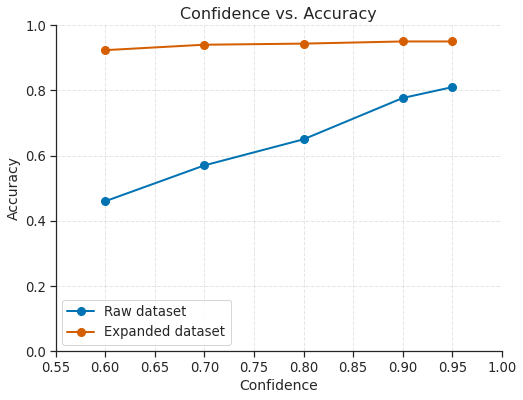

In [23]:

plt.figure(figsize=(8, 6)) 
plt.plot(confidence1, accuracy1, 'o-', color='b', linewidth=2, markersize=8, label='Raw dataset')  # 设置折线图的样式
plt.plot(confidence2, accuracy2, 'o-', color='r', linewidth=2, markersize=8, label='Expanded dataset')  # 设置折线图的样式
plt.xlabel('Confidence', fontsize=14) 
plt.ylabel('Accuracy', fontsize=14)    
plt.title('Confidence vs. Accuracy', fontsize=16)  
plt.grid(True, linestyle='--', alpha=0.5) 
plt.ylim([0, 1])      
plt.xlim([0.55, 1])     
plt.legend()          
sns.despine()  
plt.savefig('confidence_vs_accuracy.png', dpi=300)
plt.show()       